In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import pandas as pd
from time import time
import numpy as np
import re
import requests

import datetime as dt
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
os.getcwd()

import my_package.graph_functions as gf
import my_package.dicts as dc
import my_package.datepaths as dp
import my_package.calculus as cc
import my_package.graph_options as go

from keys import keys
import twitter

# Download raw data

* Raw data are downloaded from the website www.data.gouv.fr and saved (as CSV files) in the Data folder.
* Each URL is printed.
* Nothing downloaded if stored data already up-to-date

In [2]:
os.chdir('/home/edmz/DisplayDataCovid/Code')

tic = time()

address = 'https://www.data.gouv.fr/api/1/datasets/'
datasets = ['donnees-hospitalieres-relatives-a-lepidemie-de-covid-19',
            'donnees-relatives-aux-resultats-des-tests-virologiques-covid-19',
            'donnees-relatives-aux-personnes-vaccinees-contre-la-covid-19-1',
           ]
pattern = re.compile('sp-pos-quot-dep*|vacsi-a-dep*|donnees-hospitalieres-covid19*|donnees-hospitalieres-classe-age-covid19*')

# recognize the patterns in the data.gouv datasets 
for dataset in datasets:
    response = requests.get(address + dataset) # downloads all datasets 
    for resource in response.json()['resources']: # loops on the datasets
        if (pattern.match(resource['title'])) and (resource['title'] not in os.listdir('../Data/')):
    # identifies the datasets corresponding to those needed, that are not already in the Data folder
            r = requests.get(resource['url'], allow_redirects=True)
            with open('../Data/' + resource['title'], 'wb') as file:
                _ = file.write(r.content) # save the raw data in a filea
            print(resource['url'])
            
toc = time()
time_download = -tic + toc
print(f'{time_download:.2f} seconds to download the data'
     )

1.49 seconds to download the data


# Calculate

In [3]:
tic = time()

In [4]:
# Données relatives aux résultats des tests virologiques
d_tests_1, path_temp = cc.df_input('sp-pos-quot-dep')
d_tests_2 = cc.sp_tot_3C(d_tests_1)
d_tests_3 = cc.sp_compute(d_tests_2)
# Données hospitalières
d_hosp_1, path_temp = cc.df_input('donnees-hospitalieres-classe-age-covid19')
d_hosp_2 = cc.hosp_3C(d_hosp_1, keepDROM = True)
d_hosp_3 = cc.hosp_compute(d_hosp_2)
# Something with DROM (?)
#d_hosp_1, path_temp = cc.hosp_input()
#d_hosp_2 = cc.hosp_3C(d_hosp_1, True)
#d_hosp_3_DROM = cc.hosp_compute(d_hosp_2)
# Données hospitalières départementales (pas de répartition par classe d'âge)
d_hosp_dep_1, path_temp = cc.df_input('donnees-hospitalieres-covid19')
d_hosp_dep_2 = cc.hosp_dep_compute(d_hosp_dep_1)
# Données relatives aux personnes vaccinées (VACSI) 
d_vac_1, path_temp = cc.df_input('vacsi-a-dep')
d_vac_1 = d_vac_1[(d_vac_1.dep != '20') & (d_vac_1.dep != '98') & (d_vac_1.dep != '947') & (d_vac_1.dep != '99')& (d_vac_1.dep != '00')]
d_vac_2 = cc.vac_tot_3C(d_vac_1)
d_vac_3 = cc.vac_compute(d_vac_2)

../Data/sp-pos-quot-dep-2021-08-06-20h08.csv
../Data/donnees-hospitalieres-classe-age-covid19-2021-08-06-20h09.csv
../Data/donnees-hospitalieres-covid19-2021-08-06-20h09.csv
../Data/vacsi-a-dep-2021-08-06-20h05.csv


## Merge in one dataframe

In [5]:
dtes = d_tests_3
dvac = d_vac_3
dhos = d_hosp_3
dhosdep = d_hosp_dep_2
dhosdep['three_class'] = 'whole'

df = pd.merge(dhos, dhosdep, how = 'outer')
df = pd.merge(df, dvac, how = 'outer')
df = pd.merge(df, dtes, how = 'outer')
df = df.sort_values(['entity', 'three_class', 'jour'])

df.columns

Index(['entity', 'three_class', 'jour', 'hosp', 'rea', 'dc', 'dc hebdo',
       'taux hosp', 'taux rea', 'taux décès', 'HospConv', 'SSR_USLD', 'autres',
       'rad', 'n_dose1', 'n_complet', 'n_cum_dose1', 'n_cum_complet',
       'couv_dose1', 'couv_complet', 'taux dose 1', 'taux complet', 'P', 'T',
       'pop', 'P hebdo', 'T hebdo', 'incidence hebdo',
       'taux de positifs hebdo', 'taux de tests hebdo'],
      dtype='object')

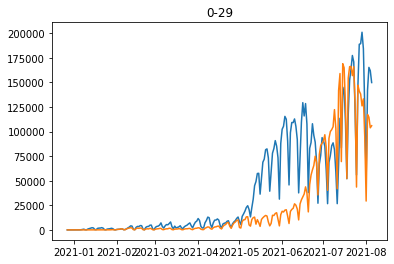

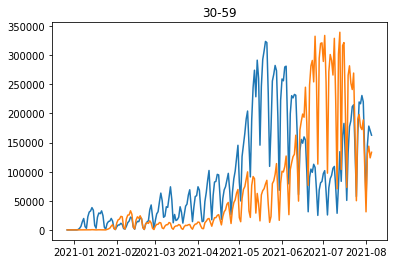

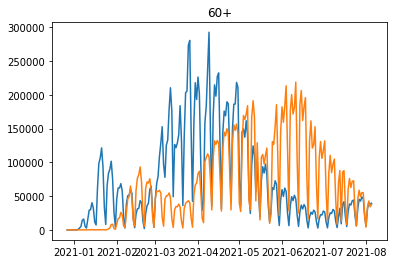

In [6]:
# Display vaccination rate in difft age classes
for age_class in ['0-29', '30-59', '60+']:
    fig, ax = plt.subplots()
    d = df.loc[df.entity == 'France'].loc[df.three_class == age_class]
    s = ax.plot(d.jour, d.n_dose1)
    s = ax.plot(d.jour, d.n_complet)
    s = plt.title(age_class)

In [7]:
df['population'] = df['pop'] 
selected_columns = ['entity', 'three_class', 'jour',
       'taux hosp', 'taux rea', 'taux décès', 'taux dose 1', 'taux complet',
       'population', 'incidence hebdo',
       'taux de positifs hebdo', 'taux de tests hebdo']
df = df[selected_columns]
df.sample(5)

entity three_class       jour  taux hosp  taux rea  taux décès  \
11364   Grand Est        0-29 2021-01-18   1.333638  0.106691         0.0   
118413         43        0-29 2021-01-08        NaN       NaN         NaN   
215299         85       30-59 2020-07-03        NaN       NaN         NaN   
99180          15        0-29 2021-02-04        NaN       NaN         NaN   
119290         44       30-59 2021-03-19        NaN       NaN         NaN   

        taux dose 1  taux complet  population  incidence hebdo  \
11364      0.066362      0.000320   1874571.0       174.653294   
118413     0.001455      0.000000     68752.0       206.539446   
215299          NaN           NaN    252097.0         0.793345   
99180      0.133711      0.005348     37394.0       147.082420   
119290     5.709412      2.201634    558131.0       173.615155   

        taux de positifs hebdo  taux de tests hebdo  
11364                 7.112598          2455.548496  
118413               10.668670          1935.943682  
215299                0.216450           366.525583  
99180                 4.403523          3340.108039  
119290                5.876645          2954.324343

In [8]:
toc = time()
time_calculus = -tic+toc
print(f'{time_calculus:.2f} seconds to compute')

9.93 seconds to compute


# Plot curves

In [9]:
tic = time()

In [10]:
regions = dc.regions
regions_metro = dc.regions_metro
regions_outre_mer = dc.regions_outre_mer
labels = ['taux hosp', 'taux rea', 'taux décès', 'taux dose 1', 'taux complet',
       'incidence hebdo',
       'taux de positifs hebdo', 'taux de tests hebdo']
print(f"regions:\n{regions}\n\nregions_metro:\n{regions_metro}\n\nregions_outre_mer:\n{regions_outre_mer}\n\nlabels:\n{labels}\n")
for label in labels:
    maximum = df[df.entity.isin(dc.regions_metro)][label].max()
    print(f"{label}:\t{maximum:.2f}")
print('\n', df.three_class.unique())

regions:
['Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire', 'Corse', 'Grand Est', 'Hauts-de-France', 'Île-de-France', 'Normandie', 'Nouvelle-Aquitaine', 'Occitanie', 'Pays de la Loire', "Provence-Alpes-Côte d'Azur", 'Mayotte', 'Guyane', 'La Réunion', 'Guadeloupe', 'Martinique']

regions_metro:
['Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire', 'Corse', 'Grand Est', 'Hauts-de-France', 'Île-de-France', 'Normandie', 'Nouvelle-Aquitaine', 'Occitanie', 'Pays de la Loire', "Provence-Alpes-Côte d'Azur"]

regions_outre_mer:
['Mayotte', 'Guyane', 'La Réunion', 'Guadeloupe', 'Martinique']

labels:
['taux hosp', 'taux rea', 'taux décès', 'taux dose 1', 'taux complet', 'incidence hebdo', 'taux de positifs hebdo', 'taux de tests hebdo']

taux hosp:	371.79
taux rea:	57.97
taux décès:	53.83
taux dose 1:	94.80
taux complet:	90.66
incidence hebdo:	1206.88
taux de positifs hebdo:	25.28
taux de tests hebdo:	20200.95

 ['0-29' '30-59'

In [11]:
def order_entities(df, entities, label, age_class):
    """
    reorders entities (regions, départements...) by descending order of the last values of
    label / age_class
    df: dataframe
    regions: list of regions
    label: one of ['taux hosp', 'taux rea', 'taux décès', 'taux dose 1', 'taux complet',
       'incidence hebdo', 'taux de positifs hebdo', 'taux de tests hebdo']
    age_class: one of ['0-29', '30-59', '60+', 'whole']
    regions_ordered: regions ordered accordingly
    """
    jour = df[df[label].notna()].jour.max()
    entities_ordered = (df[(df.jour == jour) 
                            & (df.entity.isin(entities))
                         & (df.three_class == age_class)]
                        .groupby('entity')[label]
                        .mean()
                        .sort_values(ascending = False)
                        .index
                        .tolist()) 

    return entities_ordered

# Figures "type 1" normales

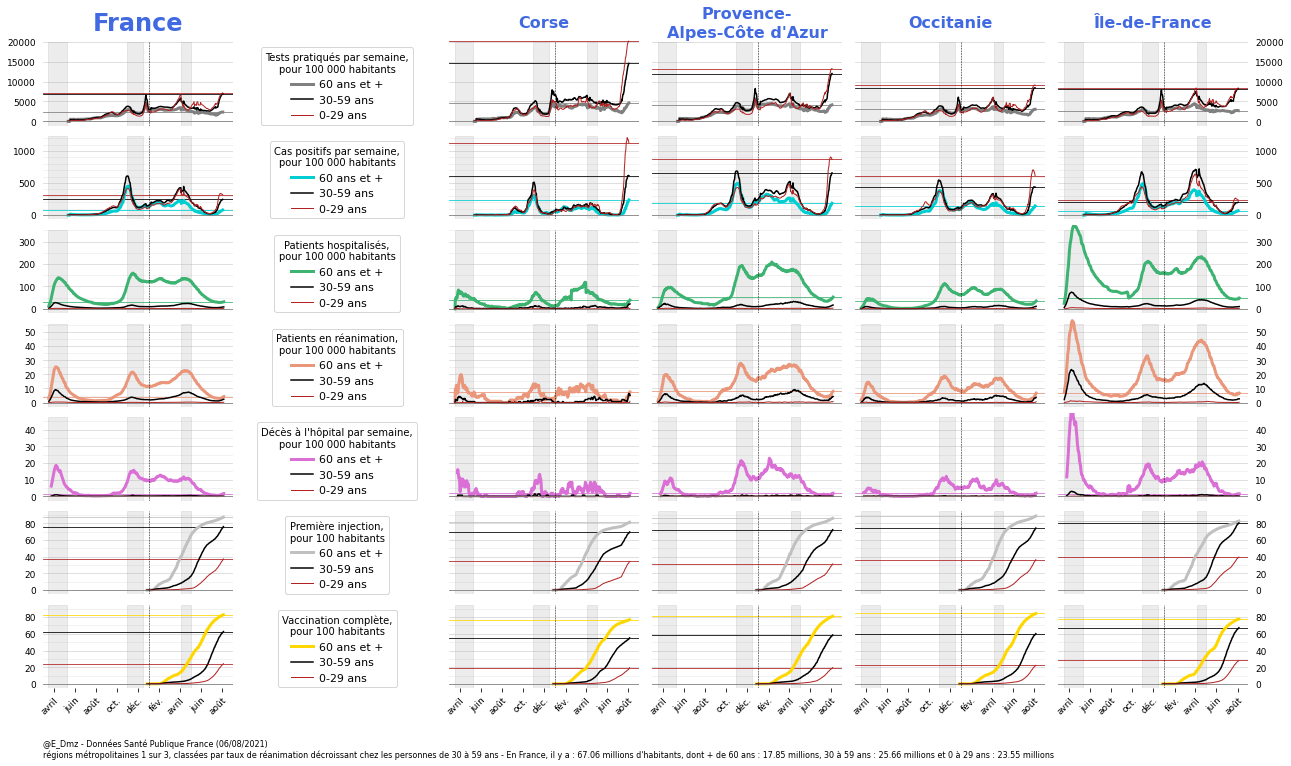

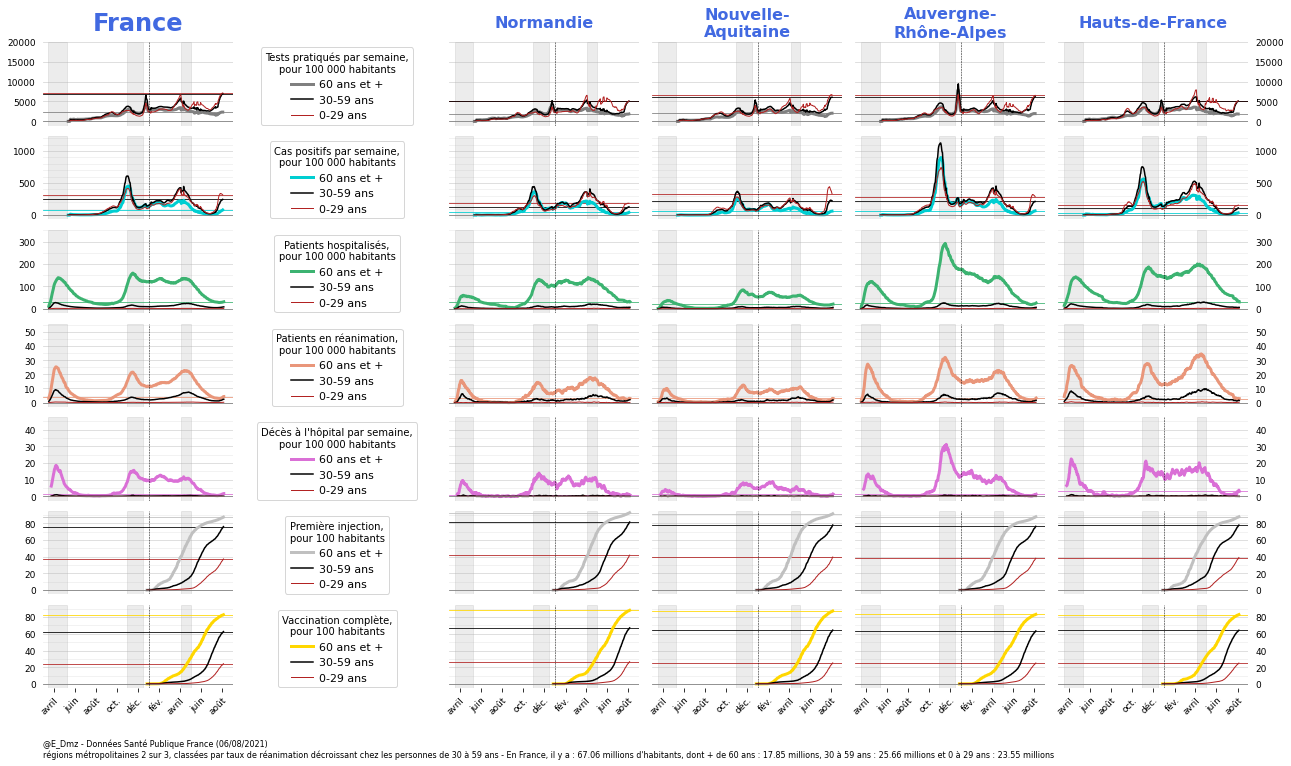

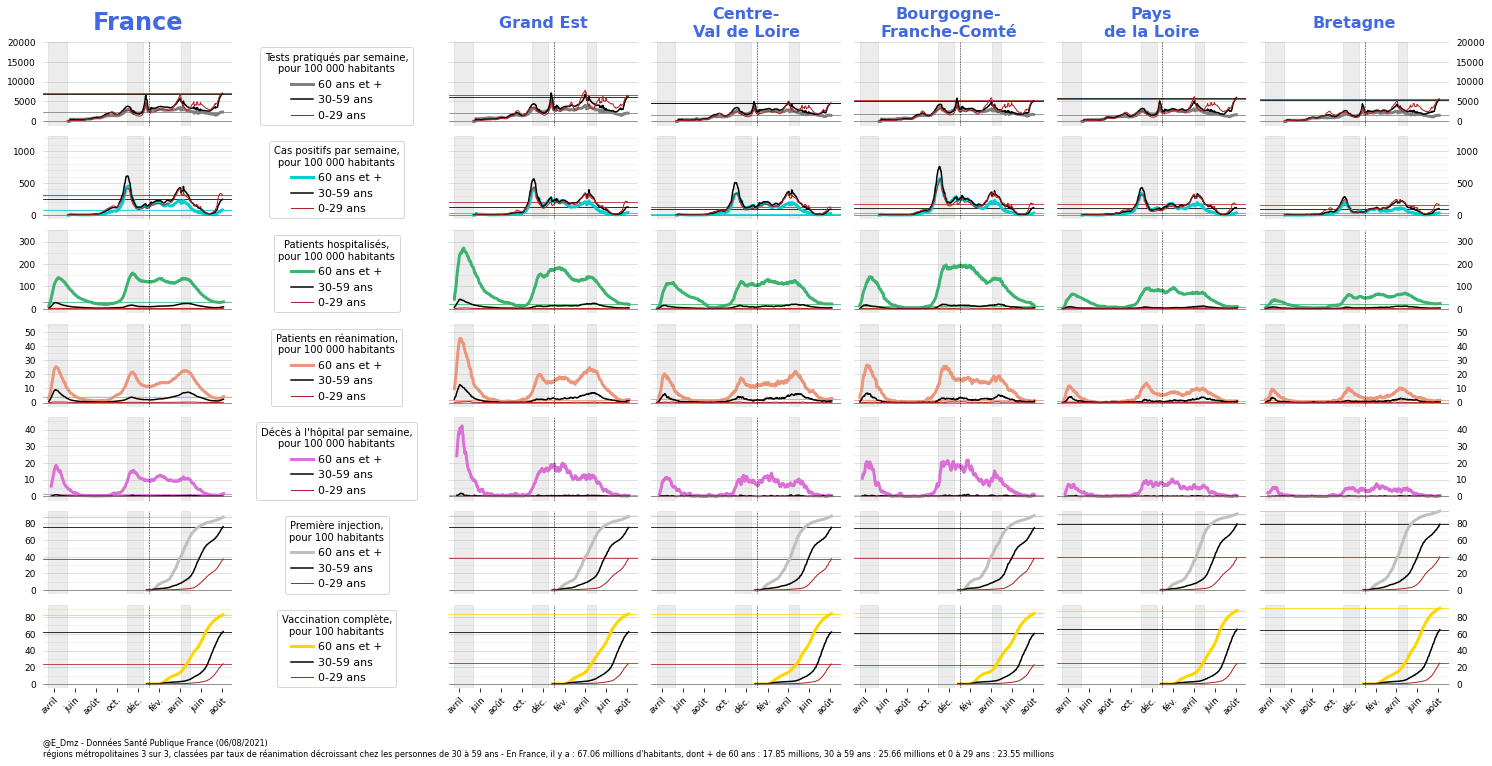

In [12]:
plt.rcParams["figure.facecolor"] = (1,1,1,1)
regions_ordered = order_entities(df, regions_metro, 'taux rea', '30-59')

title_begins = 'régions métropolitaines'
title_ends = 'classées par taux de réanimation décroissant chez les personnes de 30 à 59 ans'
graph_options = go.graph_options

gf.fig_type1(df, regions_ordered[:4], f'{title_begins} 1 sur 3, {title_ends}', graph_options)
gf.fig_type1(df, regions_ordered[4:8], f'{title_begins} 2 sur 3, {title_ends}', graph_options)
gf.fig_type1(df, regions_ordered[8:], f'{title_begins} 3 sur 3, {title_ends}', graph_options)

## Figures DROM

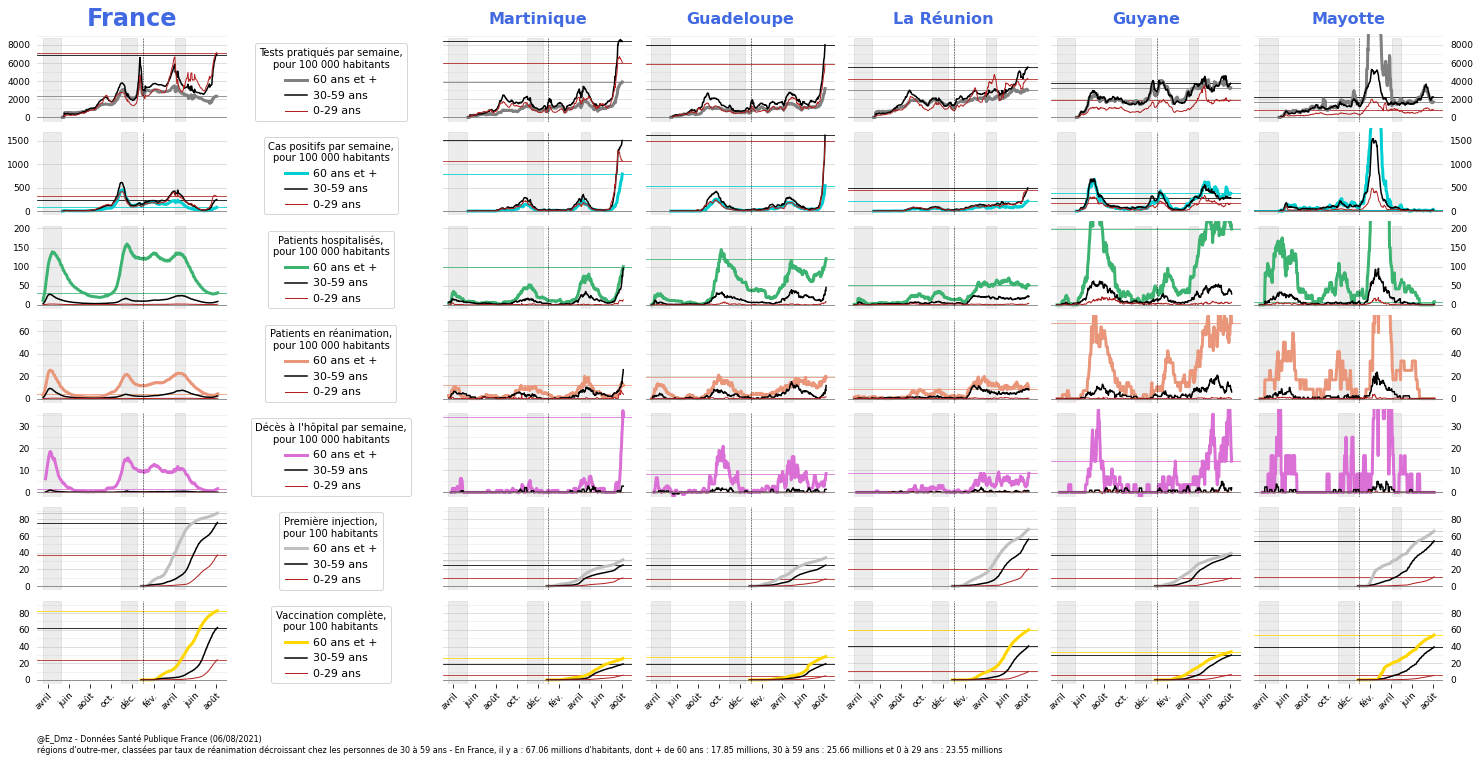

In [13]:
graph_options_alt_drom = go.scale_graph_by_age_class_last(df,regions_outre_mer, 
                         ('incidence hebdo', '30-59'),
                         ('taux de tests hebdo', '30-59'),
                         ('taux hosp', '60+'),
                         ('taux rea', '60+'),
                         ('taux décès', '60+'),
                                                     factor = 1.1
                        )

plt.rcParams["figure.facecolor"] = (1,1,1,1)
regions_ordered = order_entities(df, regions_outre_mer, 'taux rea', '30-59')

title_begins = 'régions d\'outre-mer'
title_ends = 'classées par taux de réanimation décroissant chez les personnes de 30 à 59 ans'

graph_options = graph_options_alt_drom

# title_begins = 'zoom régions d\'outre-mer'
gf.fig_type1(df, regions_ordered, f'{title_begins}, {title_ends}', graph_options)

### Figures zoom

In [14]:
# ### Figures zoom
# graph_options_alt_metro = go.scale_graph_by_age_class_last(df, regions_metro, 
#                          ('incidence hebdo', '30-59'),
#                          ('taux de tests hebdo', '30-59'),
#                          ('taux hosp', '60+'),
#                          ('taux rea', '60+'),
#                          ('taux décès', '60+'),
#                                                       factor = 1.1
#                         )

# plt.rcParams["figure.facecolor"] = (1,1,1,1)
# regions_ordered = order_entities(df, regions_metro, 'taux rea', '30-59')
# title_begins = 'zoom régions métropolitaines'
# title_ends = 'classées par taux de réanimation décroissant chez les personnes de 30 à 59 ans'
# graph_options = graph_options_alt_metro


# gf.fig_type1(df, regions_ordered[:4], f'{title_begins} 1 sur 3, {title_ends}', graph_options)
# gf.fig_type1(df, regions_ordered[4:8], f'{title_begins} 2 sur 3, {title_ends}', graph_options)
# gf.fig_type1(df, regions_ordered[8:], f'{title_begins} 3 sur 3, {title_ends}', graph_options)



# # # regions_ordered = order_entities(df, regions_metro, 'taux rea', '60+')
# # regions_ordered = order_entities(df, regions_metro, 'incidence hebdo', '0-29')

# # title_begins = 'zoom régions métropolitaines'
# # title_ends = 'classées par incidence hebdomadaire décroissante chez les 0-29 ans'

# # graph_options = graph_options_alt_metro

# # gf.fig_type1(df, regions_ordered[:4], f'{title_begins} 1 sur 3, {title_ends}', graph_options)
# # gf.fig_type1(df, regions_ordered[4:8], f'{title_begins} 2 sur 3, {title_ends}', graph_options)
# # gf.fig_type1(df, regions_ordered[8:], f'{title_begins} 3 sur 3, {title_ends}', graph_options)

# Figures Type 0

## France et quelques régions

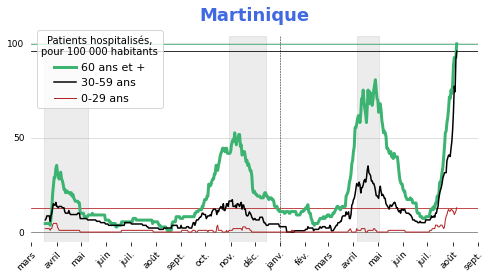

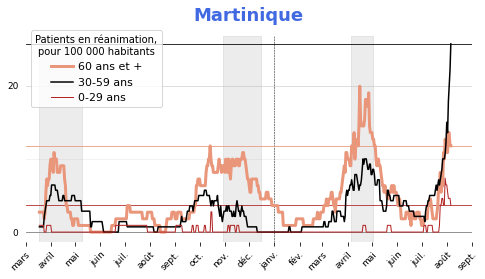

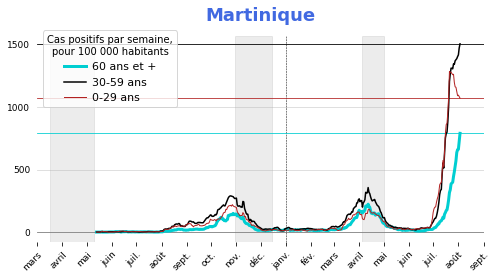

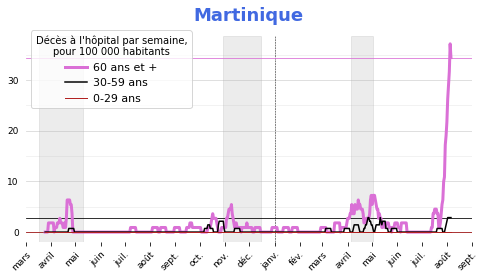

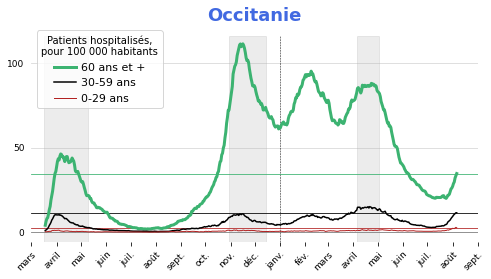

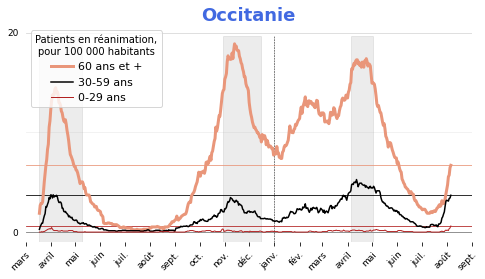

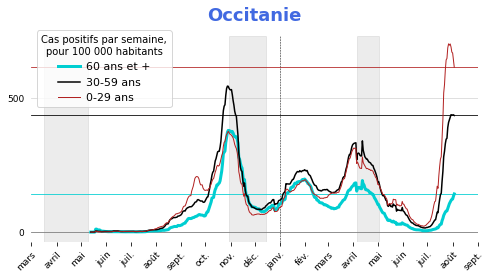

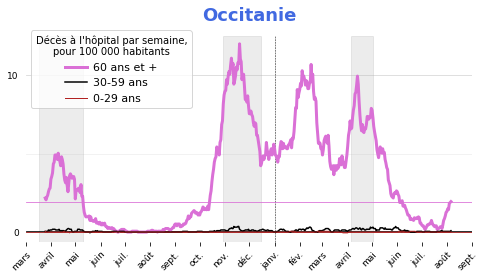

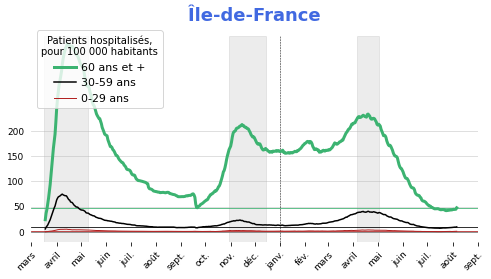

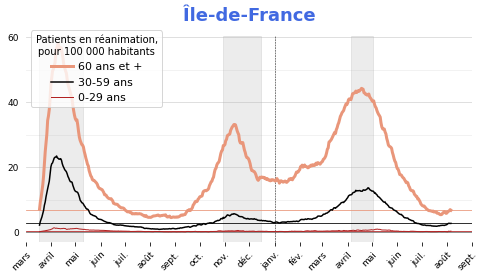

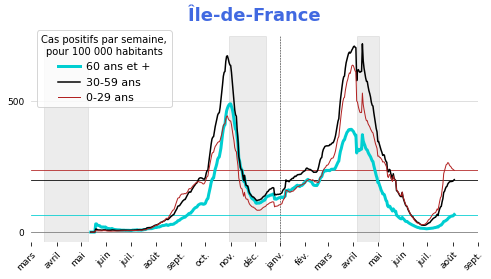

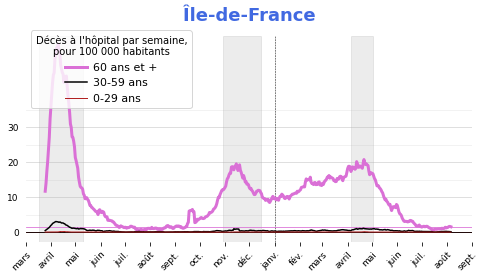

In [15]:

# entities = ['France', 'Occitanie', "Provence-Alpes-Côte d'Azur", 'Corse', 'Île-de-France', 'Martinique', 'Guyane']
entities = ['Martinique', 'Occitanie', 'Île-de-France']
labels = ['taux hosp','taux rea', 'incidence hebdo', 'taux décès']

for entity in entities:

    for label in labels:
        plt.rcParams["figure.facecolor"] = (1,1,1,1)
        gf.simple_figure(df, entity, label, hline = ['0-29', '30-59', '60+'], graph_options = go.graph_options, autoscale = True)


In [16]:

# entities = ['Hauts-de-France',]
# labels = ['taux hosp','taux rea', 'incidence hebdo', 'taux décès']

# for entity in entities:

#     for label in labels:
#         plt.rcParams["figure.facecolor"] = (1,1,1,1)
#         gf.simple_figure(df, entity, label, hline = ['0-29', '30-59', '60+'], graph_options = go.graph_options, autoscale = True)


In [17]:
toc = time()
time_graph = -tic+toc
print(f'{time_graph:.2f} seconds to plot')

51.96 seconds to plot


# Tweet

In [18]:
tic = time()

import twitter
from my_package.tweets import tweets, media

print(len(tweets), len(media))

11 11


In [19]:
for tweet in tweets:
    print(len(tweet))

97
35
30
59
103
224
215
225
102
18
25


In [20]:
api = twitter.Api(**keys)
num_tweets = len(tweets)

for i in range(len(tweets)): # loop  accross the tweets
    
    tweet_begins = ''
    
    tweet_ends = f'\n\n{i+1}/{num_tweets}' if i ==0 else f'\n\n🤖 {i+1}/{num_tweets}'
    
    status = api.PostUpdate(
        f'{tweet_begins}{tweets[i]}{tweet_ends}',
        media = media[i],
        in_reply_to_status_id = None if i==0 else status.id,
        )
    status_0 = status if i == 0 else status_0

toc = time()
time_publish = -tic+toc
print(f'{time_publish:.2f} seconds to publish')

status = api.PostUpdate(f'🤖 Pour faire cette MAJ, il m\'a fallu : \n\
{time_download:.1f} s pour télécharger, \n\
{time_calculus:.1f} s pour calculer,\n\
{time_graph:.1f} s pour tracer,\n\
et {time_publish:.1f} s pour publier',
                      in_reply_to_status_id = status.id)
status = api.PostRetweet(status_0.id)

17.12 seconds to publish


## Réponse requête Twitter

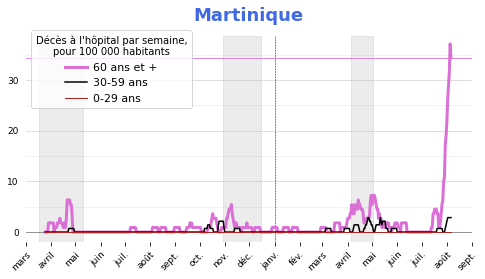

In [21]:
gf.simple_figure(df, 'Martinique', 'taux décès', autoscale = True)

In [22]:
graph_options = go.scale_graph_by_age_class_last(df, ['Martinique'], ('incidence hebdo', '30-59'), ('taux rea', '30-59'), ('taux hosp', '60+'), factor = 1.1)

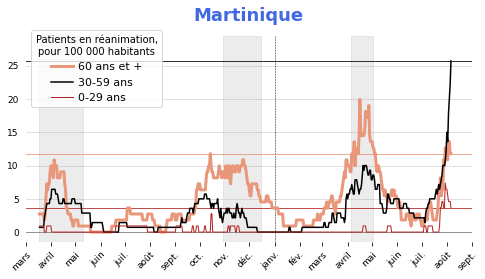

In [23]:
gf.simple_figure(df, 'Martinique', 'taux rea', graph_options = graph_options, hline = ['0-29', '30-59', '60+'])

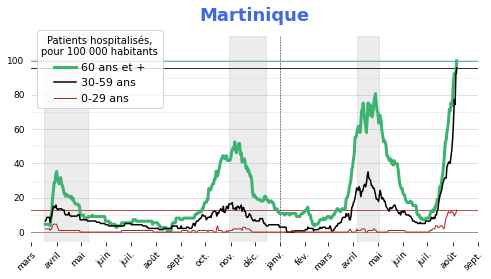

In [24]:
gf.simple_figure(df, 'Martinique', 'taux hosp', graph_options = graph_options, hline = ['0-29', '30-59', '60+'])

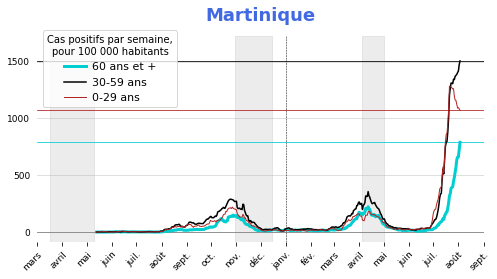

In [25]:
gf.simple_figure(df, 'Martinique', 'incidence hebdo', graph_options = graph_options, hline = ['0-29', '30-59', '60+'])

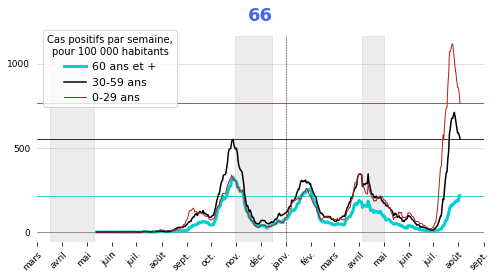

In [26]:
gf.simple_figure(df, '66', 'incidence hebdo', autoscale = True)

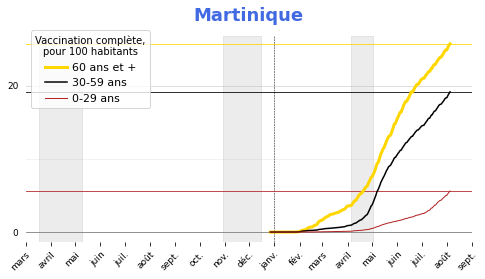

In [27]:
gf.simple_figure(df, 'Martinique', 'taux complet', autoscale = True)

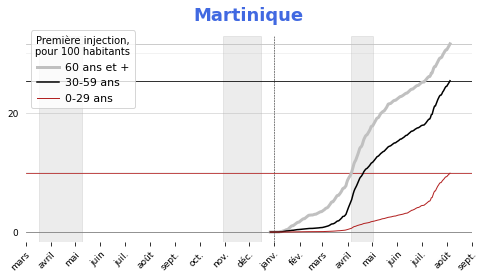

In [28]:
gf.simple_figure(df, 'Martinique', 'taux dose 1', autoscale = True)

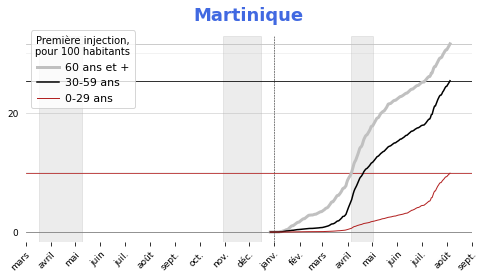

In [29]:

gf.simple_figure(df, 'Martinique', 'taux dose 1')

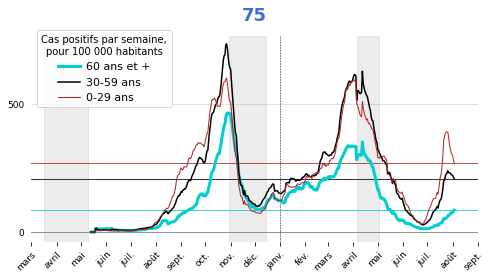

In [30]:
gf.simple_figure(df, '75', 'incidence hebdo', autoscale = True)

In [31]:
graph_options

{'incidence hebdo': {'ymax': 737.3994991205274,
  'main_color': 'darkturquoise',
  'title': 'Cas positifs par semaine,\npour 100 000 habitants',
  'majloc': [0, 500, 1000, 1500],
  'minloc': [0, 500, 1000, 1500],
  'rescale': 1.1},
 'taux de tests hebdo': {'ymax': 9210.824582325364,
  'main_color': 'gray',
  'title': 'Tests pratiqués par semaine,\npour 100 000 habitants',
  'majloc': [0, 2000, 4000, 6000, 8000],
  'minloc': [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]},
 'taux de positifs hebdo': {'ymax': 26,
  'main_color': 'olivedrab',
  'title': 'Tests positifs,\npour 100 tests\n(moyenne hebdomadaire)',
  'majloc': [0, 5, 10, 15, 20, 25],
  'minloc': [0, 5, 10, 15, 20, 25]},
 'taux hosp': {'ymax': 109.67208703888336,
  'main_color': 'mediumseagreen',
  'title': 'Patients hospitalisés,\npour 100 000 habitants',
  'majloc': [0, 20, 40, 60, 80, 100],
  'minloc': [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
  'rescale': 1.1},
 'taux rea': {'ymax': 28.303391342071787,
  'ma

In [32]:
graph_options = go.scale_graph_by_age_class_max(df, ['Guyane'], ('taux décès', '60+'))

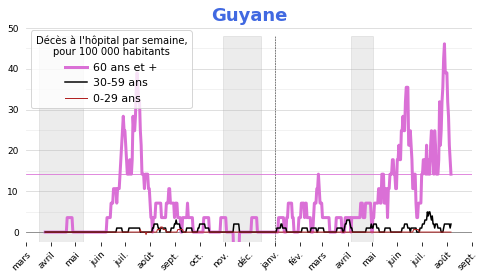

In [33]:
gf.simple_figure(df, 'Guyane', 'taux décès', graph_options = graph_options, autoscale = True)

# Autres graphes

In [34]:

# gf.simple_figure(d, 'Grand Est', 'taux décès')
# gf.simple_figure(d, 'Corse', 'taux complet')
# gf.simple_figure(d, 'Nouvelle-Aquitaine', 'taux rea')
# gf.simple_figure(d, 'Hauts-de-France', 'taux de tests hebdo')

In [35]:
# gf.simple_figure(d, 'France', 'taux hosp')
# gf.simple_figure(d, 'France', 'taux rea')
# gf.simple_figure(d, 'France', 'taux décès')

In [36]:
# gf.simple_figure(d, 'Mayotte', 'incidence hebdo')
# gf.simple_figure(d, 'Mayotte', 'taux rea')
# gf.simple_figure(d, '976', 'incidence hebdo')

In [37]:
def time_interval(jour = pd.Timestamp.now(), days = 1):
    period = pd.Timedelta(days, 'D')
    right = jour
    left = pd.Timestamp(jour - period)
    return pd.Interval(left, right)

time_interval()

Interval('2021-08-05 20:36:59.364972', '2021-08-06 20:36:59.364972', closed='right')

In [38]:
def last_value(df, entity, age_class, label):
    jour = df[df[label].notna()].jour.max()
    last_value = (df[(df.jour == jour) 
                    & (df.entity == entity)
                    & (df.three_class == age_class)])[label].values
    return last_value[0]

In [39]:
def max_last_value(entities, age_class, label):
    last_values = []
    for entity in entities:
        last_values.append(last_value(entity, age_class, label))
    return max(last_values)  

In [40]:
# jour = df[df['incidence hebdo'].notna()].jour.max()
# jour

# jour - pd.Timedelta(1,'D')

# df[(df.jour < jour)].jour.max()

# pd.Timestamp.now()

In [41]:
df[df.entity.isin(regions_metro)].max(axis = 0)

entity                          Île-de-France
three_class                             whole
jour                      2021-08-06 00:00:00
taux hosp                          371.786941
taux rea                            57.965072
taux décès                          53.833223
taux dose 1                         94.799685
taux complet                        90.661336
population                         12278210.0
incidence hebdo                   1206.876251
taux de positifs hebdo              25.280999
taux de tests hebdo              20200.949802
dtype: object

### Régions, échelle normale, classées par taux de réa

In [42]:
# regions_ordered = order_entities(df, regions_metro, 'taux rea', '60+')
# title_begins = 'régions métropolitaines'
# title_ends = 'classées par taux de réanimation décroissant chez les personnes de 60 ans et +'
# graph_options = go.graph_options

# gf.fig_type1(df, regions_ordered[:4], f'{title_begins} 1 sur 3, {title_ends}', graph_options)
# gf.fig_type1(df, regions_ordered[4:8], f'{title_begins} 2 sur 3, {title_ends}', graph_options)
# gf.fig_type1(df, regions_ordered[8:], f'{title_begins} 3 sur 3, {title_ends}', graph_options)

In [43]:
entity = '75'
age_class = '60+' 
label = 'taux complet'
d = df[ (df.entity == entity)
                    & (df.three_class == age_class) ]
last_day = d.jour.max()
d[d.jour == last_day][label].values[0]

82.79656379726732

In [44]:
d = df[ (df.entity == entity)
                    & (df.three_class == age_class) & df[label].notna()]
d

entity three_class       jour  taux hosp  taux rea  taux décès  \
139691     75         60+ 2020-12-27        NaN       NaN         NaN   
139694     75         60+ 2020-12-28        NaN       NaN         NaN   
139697     75         60+ 2020-12-29        NaN       NaN         NaN   
139700     75         60+ 2020-12-30        NaN       NaN         NaN   
139703     75         60+ 2020-12-31        NaN       NaN         NaN   
...       ...         ...        ...        ...       ...         ...   
140342     75         60+ 2021-08-01        NaN       NaN         NaN   
140345     75         60+ 2021-08-02        NaN       NaN         NaN   
140348     75         60+ 2021-08-03        NaN       NaN         NaN   
140351     75         60+ 2021-08-04        NaN       NaN         NaN   
140354     75         60+ 2021-08-05        NaN       NaN         NaN   

        taux dose 1  taux complet  population  incidence hebdo  \
139691     0.004114      0.000000    486118.0       128.981029   
139694     0.007817      0.000000    486118.0       127.746761   
139697     0.009668      0.000000    486118.0       123.632534   
139700     0.016868      0.000000    486118.0       124.455379   
139703     0.022011      0.000000    486118.0       123.426822   
...             ...           ...         ...              ...   
140342    88.242155     82.102288    486118.0        78.170321   
140345    88.386565     82.292571    486118.0        81.873125   
140348    88.554014     82.475243    486118.0        85.781641   
140351    88.702126     82.640429         NaN              NaN   
140354    88.845507     82.796564         NaN              NaN   

        taux de positifs hebdo  taux de tests hebdo  
139691                2.361671          5461.431175  
139694                2.527061          5055.151218  
139697                2.777778          4450.771212  
139700                3.132443          3973.109410  
139703                3.455624          3571.766526  
...                        ...                  ...  
140342                2.148835          3637.799876  
140345                2.323274          3524.041488  
140348                2.461920          3484.339193  
140351                     NaN                  NaN  
140354                     NaN                  NaN  

[222 rows x 12 columns]

In [45]:
# gf.simple_figure(d, 'Guyane', 'taux hosp')
# gf.simple_figure(d, 'Guyane', 'taux rea')
# gf.simple_figure(d, 'Guyane', 'taux décès')
# gf.simple_figure(d, '973', 'taux dose 1')
# gf.simple_figure(d, '973', 'taux complet')


In [46]:
# gf.simple_figure(d, '973', 'incidence hebdo')
# gf.simple_figure(d, '93', 'incidence hebdo')
# gf.simple_figure(d, '971', 'incidence hebdo')

# gf.simple_figure(d, '971', 'incidence hebdo')

In [47]:
# gf.simple_figure(d, 'France', 'incidence hebdo')
# gf.simple_figure(d, 'Île-de-France', 'incidence hebdo')
# gf.simple_figure(d, '75', 'incidence hebdo')


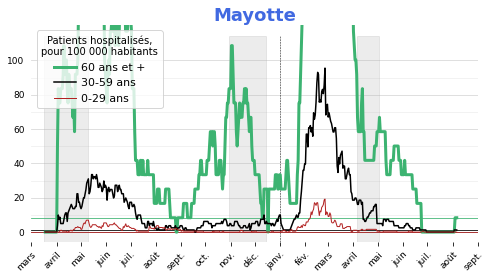

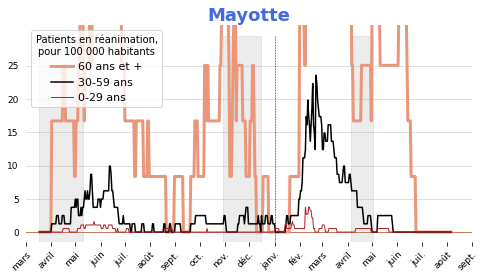

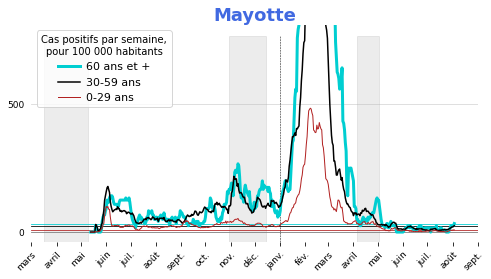

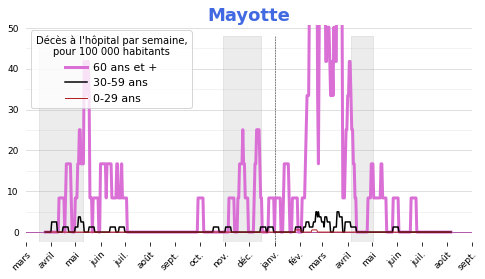

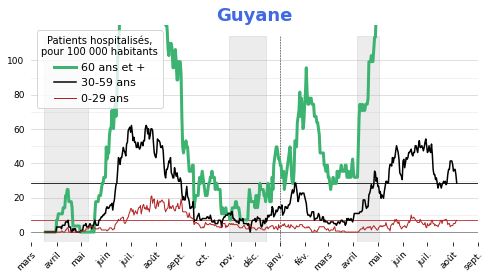

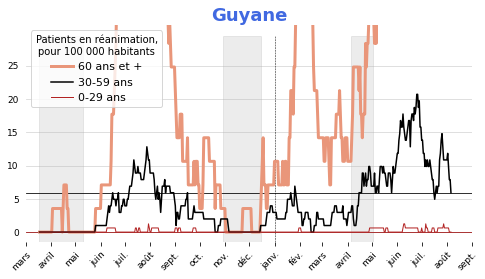

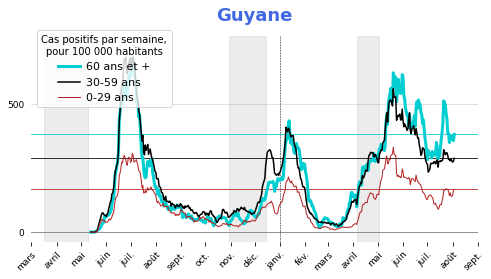

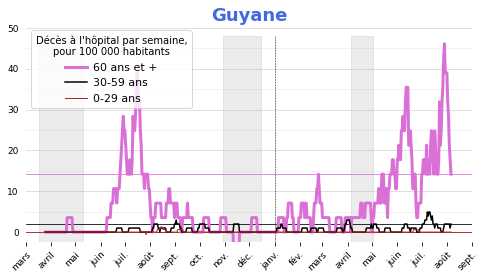

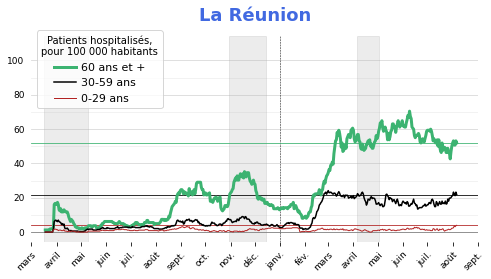

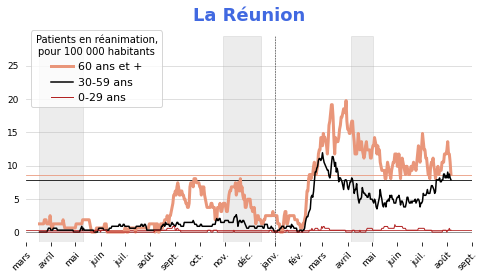

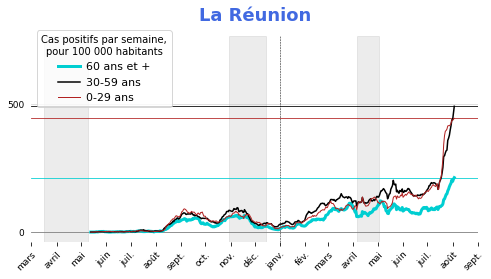

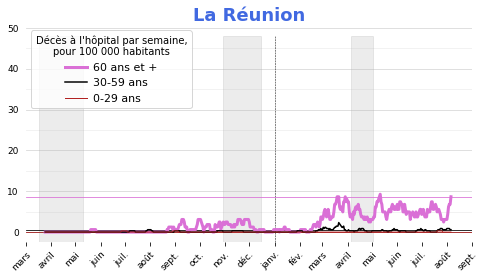

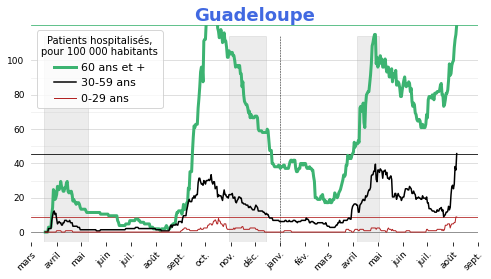

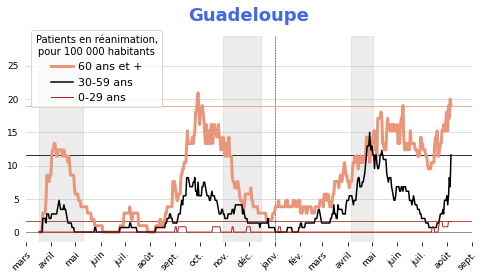

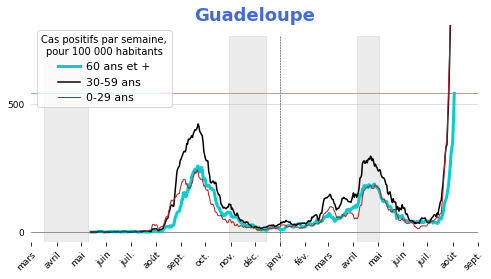

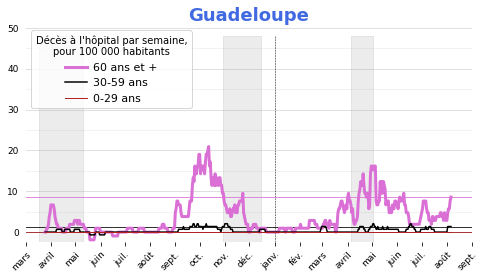

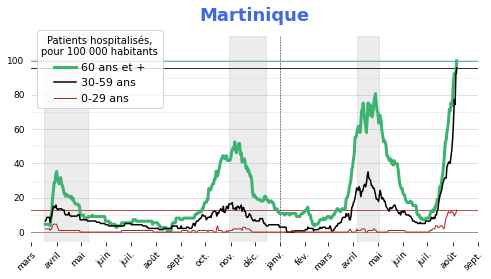

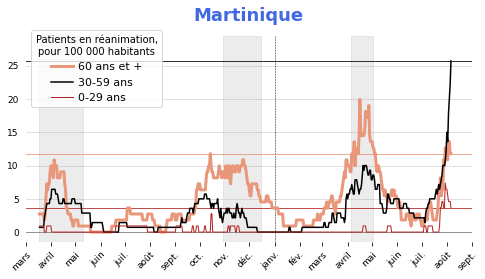

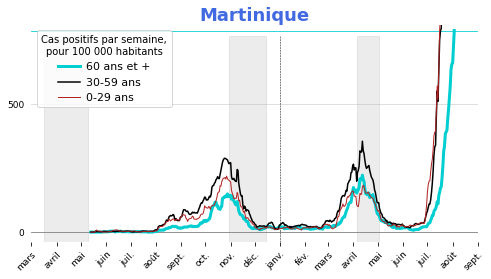

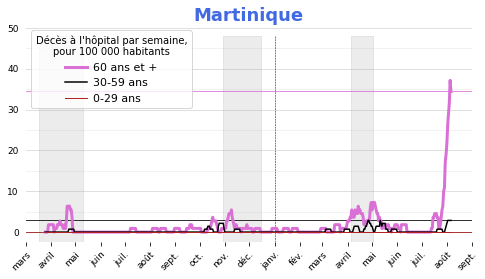

In [48]:
entities = regions_outre_mer
labels = ['taux hosp','taux rea', 'incidence hebdo', 'taux décès']
graph_options = go.graph_options

for entity in entities:
    for label in labels:
        gf.simple_figure(df, entity, label, graph_options = graph_options, hline = ['0-29', '30-59', '60+'])


In [49]:
labels

['taux hosp', 'taux rea', 'incidence hebdo', 'taux décès']

In [50]:
graph_options['taux de positifs hebdo']['ymax'] = 5

In [51]:
graph_options = go.graph_options_auto({'taux de positifs hebdo': 7.5})

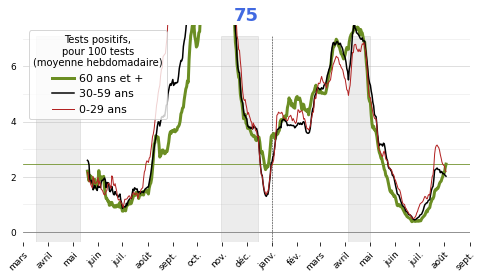

In [52]:
gf.simple_figure(df, '75', 'taux de positifs hebdo', graph_options = graph_options)

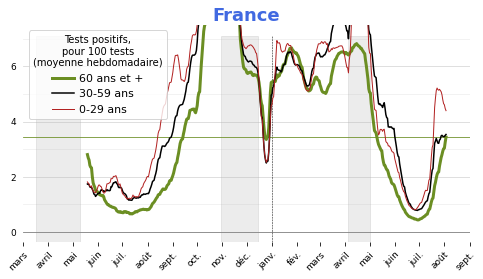

In [53]:
gf.simple_figure(df, 'France', 'taux de positifs hebdo', graph_options = graph_options)

In [54]:
graph_options = go.graph_options_auto({'taux de tests hebdo': 7500})

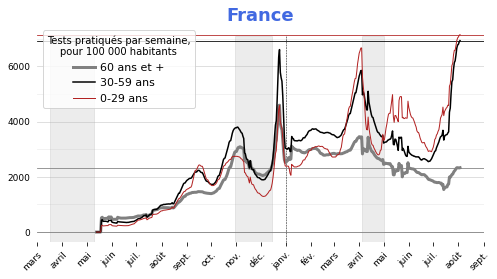

In [55]:
gf.simple_figure(df, 'France', 'taux de tests hebdo', graph_options = graph_options)

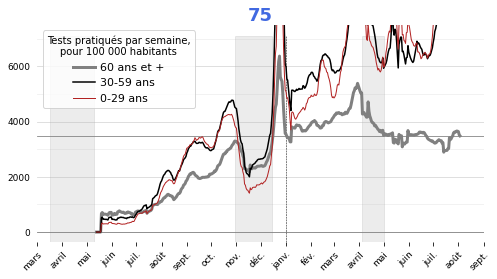

In [56]:
gf.simple_figure(df, '75', 'taux de tests hebdo', graph_options = graph_options)

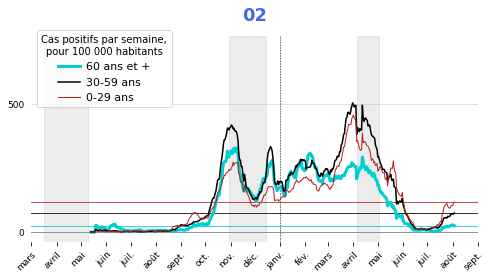

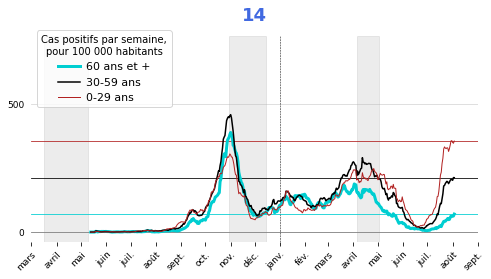

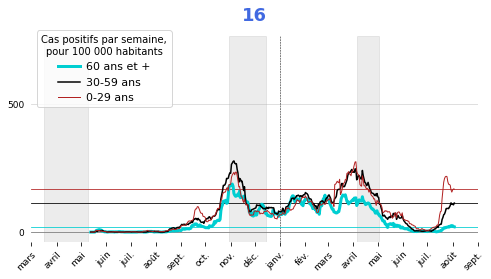

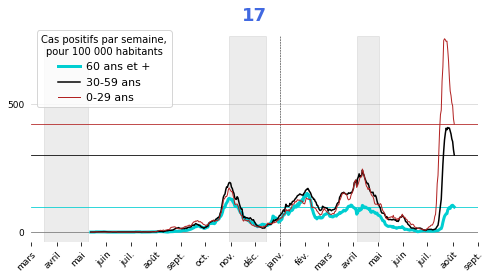

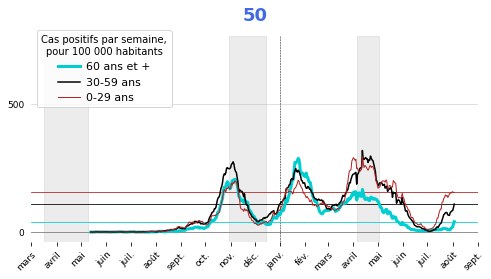

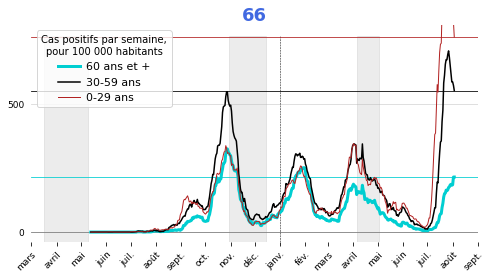

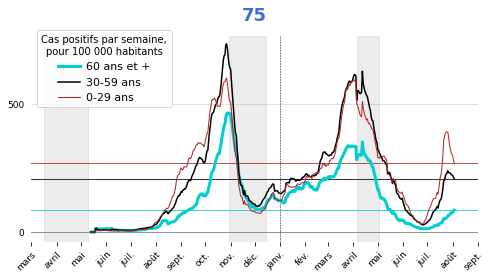

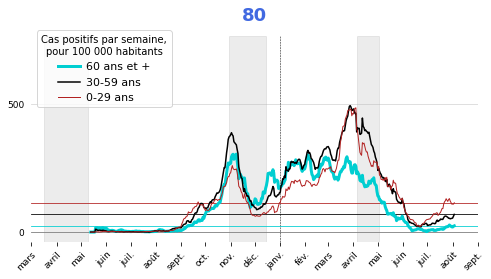

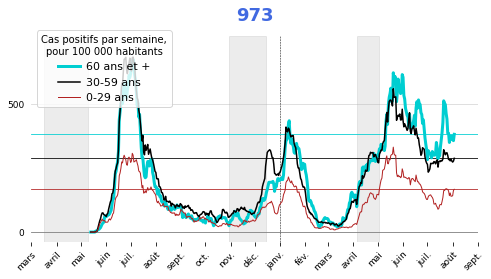

In [57]:
for entity in ['02', '14', '16', '17', '50', '66', '75', '80', '973']:
    gf.simple_figure(df, entity, 'incidence hebdo', graph_options = graph_options)

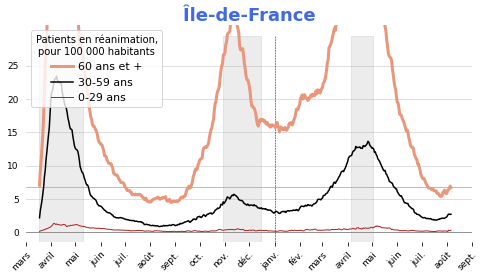

In [58]:
gf.simple_figure(df, 'Île-de-France', 'taux rea', graph_options = graph_options)

## Départements d'Île-de-France

In [59]:
entities = ['75', '93', '92', '94', '91', '95', '77', '78']
graph_options = go.scale_graph_by_age_class(df, entities,
                         ('incidence hebdo', '0-29'),
                         ('taux de tests hebdo', '0-29'),
                        )


entities = order_entities(df, entities, 'incidence hebdo', '0-29')

labels = ['incidence hebdo',]

for entity in entities:
    for label in labels:
        gf.simple_figure(df, entity, label, graph_options = graph_options)

AttributeError: module 'my_package.graph_options' has no attribute 'scale_graph_by_age_class'

## Martinique et Guyane

In [ ]:
entities = ['Martinique', 'Guyane']
labels = ['incidence hebdo','taux rea', 'taux dose 1', 'taux complet',]
graph_options_alt_drom = go.scale_graph_by_age_class(df,regions_outre_mer, 
                         ('incidence hebdo', '0-29'),
                         ('taux de tests hebdo', '0-29'),
                         ('taux hosp', '60+'),
                         ('taux rea', '60+'),
                         ('taux décès', '60+'),
                        )
graph_options = graph_options_alt_drom

for entity in entities:
    for label in labels:
        gf.simple_figure(df, entity, label, graph_options = graph_options)
        
toc = time()
time_graph = -tic + toc

In [ ]:
regions_metro

In [ ]:
graph_options['taux rea']['ymax']= 20
graph_options['taux rea']['majloc'], graph_options['taux rea']['minloc']= go.loc_auto(20)
# graph_options['taux rea']['ymax']= 20



In [ ]:
for entity in ['Occitanie', 'Martinique', 'La Réunion', 'Île-de-France']:
    for label in ['taux rea','incidence hebdo', 'taux complet']:
        gf.simple_figure(df, entity, label, graph_options = graph_options, hline = ['0-29', '30-59', '60+'])

In [ ]:
d = df.loc[(df.entity == 'France') & (df.three_class == '0-29'), df.dtypes != 'object']

In [ ]:
d.loc[:,d.dtypes != 'object']

In [ ]:
d

In [ ]:
d.shift(1)

In [ ]:
(d.shift(7)['jour']-d['jour']).unique()

In [ ]:
d.shift(7)['taux décès']/d['incidence hebdo']

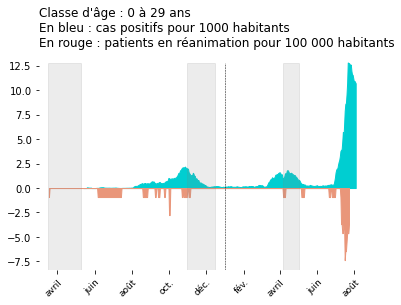

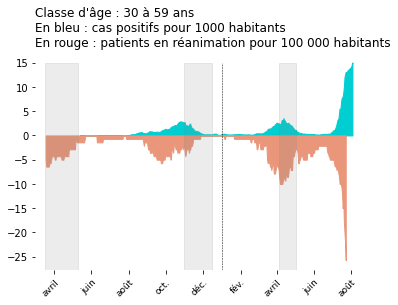

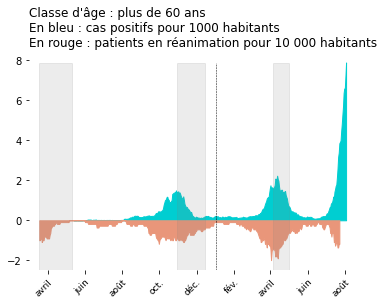

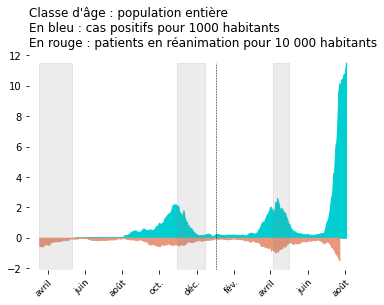

In [12]:
%matplotlib inline
age_class_dict =dict(zip(['0-29', '30-59', '60+', 'whole'], ['0 à 29 ans', '30 à 59 ans', 'plus de 60 ans', 'population entière']))
for age_class, coeff in zip(['0-29', '30-59', '60+', 'whole'], [-100, -100, -10, -10]):
    d = df[(df.entity == 'Martinique') & (df.three_class == age_class)]
    fig, ax = plt.subplots()
    s=ax.spines['top'].set_visible(False)
    s=ax.spines['right'].set_visible(False)
    s=ax.spines['bottom'].set_visible(False)
    s=ax.spines['left'].set_visible(False)
    s=ax.set_xlim(dt.datetime(2020, 3, 1), 
                    dt.datetime(2021, 9, 1))
    s=ax.axvline(dt.datetime(2021, 1, 1), 
                    ymin = 0, ymax = .95, 
                    c = 'black', linewidth = 0.5, linestyle = '--')
    s=ax.axvspan(dt.datetime(2020, 3, 17), 
                    dt.datetime(2020, 5, 10),
                    ymin = 0, ymax = .95, alpha=0.15, color='gray')
    s=ax.axvspan(dt.datetime(2020, 10, 30), 
                    dt.datetime(2020, 12, 15),
                    ymin = 0, ymax = .95, alpha=0.15, color='gray')
    s=ax.axvspan(dt.datetime(2021, 4, 5), 
                    dt.datetime(2021, 5, 2),
                    ymin = 0, ymax = .95, alpha=0.15, color='gray')
    incidence_to_plot = d['incidence hebdo']/100
    s = ax.fill_between(d.jour, incidence_to_plot, color = 'darkturquoise')
#     rea_to_plot = d['taux rea']*coeff/100
#     s = ax.fill_between(d.jour - pd.Timedelta(14,'D'), rea_to_plot, color = 'darksalmon')
    rea_to_plot = d.shift(-14)['taux rea']*coeff/100
    s = ax.fill_between(d.jour, rea_to_plot, color = 'darksalmon')
#     ratio_to_plot = - rea_to_plot/incidence_to_plot
#     s = ax.plot(d.jour, ratio_to_plot)
    s = ax.xaxis.set_tick_params(bottom = True, labelsize = 9)
    xloc = []
    for i in range(9):
        xloc.append(dt.datetime(2020, 4  + 2*i, 1) if 2*i <= 8
                        else dt.datetime(2021, 2*i - 8, 1)
                   )
    labels = ['avril', 'juin', 
                'août', 'oct.', 'déc.', 
                'fév.', 'avril', 
                  'juin','août']
    s=ax.xaxis.set_ticks(xloc)
    s=ax.xaxis.set_ticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")
    age_class_txt = age_class_dict[age_class]
    rate_specifier = f'{-1000 * coeff:0,d}'.replace(',', ' ')
    s=plt.title(f'Classe d\'âge : {age_class_txt}\nEn bleu : cas positifs pour 1000 habitants\nEn rouge : patients en réanimation pour {rate_specifier} habitants', loc = 'left')

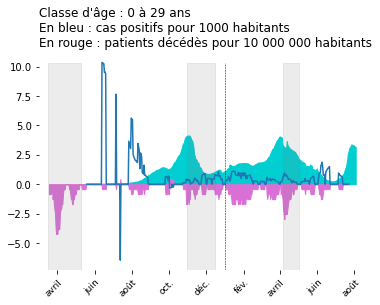

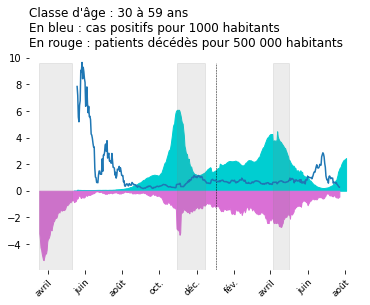

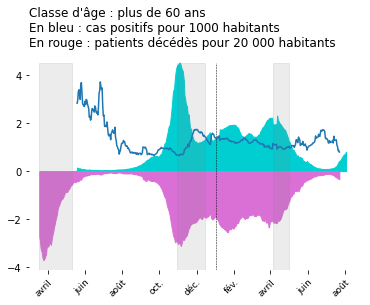

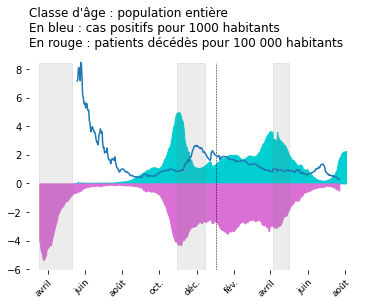

In [13]:
%matplotlib inline
for age_class, coeff in zip(['0-29', '30-59', '60+', 'whole'], [-10000, -500, -20, -100]):
    d = df[(df.entity == 'France') & (df.three_class == age_class)]
    fig, ax = plt.subplots()
    s=ax.spines['top'].set_visible(False)
    s=ax.spines['right'].set_visible(False)
    s=ax.spines['bottom'].set_visible(False)
    s=ax.spines['left'].set_visible(False)
    s=ax.set_xlim(dt.datetime(2020, 3, 1), 
                    dt.datetime(2021, 9, 1))
    s=ax.axvline(dt.datetime(2021, 1, 1), 
                    ymin = 0, ymax = .95, 
                    c = 'black', linewidth = 0.5, linestyle = '--')
    s=ax.axvspan(dt.datetime(2020, 3, 17), 
                    dt.datetime(2020, 5, 10),
                    ymin = 0, ymax = .95, alpha=0.15, color='gray')
    s=ax.axvspan(dt.datetime(2020, 10, 30), 
                    dt.datetime(2020, 12, 15),
                    ymin = 0, ymax = .95, alpha=0.15, color='gray')
    s=ax.axvspan(dt.datetime(2021, 4, 5), 
                    dt.datetime(2021, 5, 2),
                    ymin = 0, ymax = .95, alpha=0.15, color='gray')
#     s=ax.fill_between(d.jour, d['incidence hebdo']/100, color = 'darkturquoise')
#     s=ax.fill_between(d.jour - pd.Timedelta(14,'D'), d['taux décès']*coeff/100, color = 'orchid')
    
    incidence_to_plot = d['incidence hebdo']/100
    s = ax.fill_between(d.jour, incidence_to_plot, color = 'darkturquoise')
    dc_to_plot = d.shift(-14)['taux décès']*coeff/100
    s = ax.fill_between(d.jour, dc_to_plot, color = 'orchid')
    ratio_to_plot = - dc_to_plot/incidence_to_plot
    s = ax.plot(d.jour, ratio_to_plot)
    s=ax.xaxis.set_tick_params(bottom = True, labelsize = 9)
    xloc = []
    for i in range(9):
        xloc.append(dt.datetime(2020, 4  + 2*i, 1) if 2*i <= 8
                        else dt.datetime(2021, 2*i - 8, 1)
                   )
    labels = ['avril', 'juin', 
                'août', 'oct.', 'déc.', 
                'fév.', 'avril', 
                  'juin','août']
    s=ax.xaxis.set_ticks(xloc)
    s=ax.xaxis.set_ticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")
    age_class_txt = age_class_dict[age_class]
    rate_specifier = f'{-1000 * coeff:0,d}'.replace(',', ' ')
    s=plt.title(f'Classe d\'âge : {age_class_txt}\nEn bleu : cas positifs pour 1000 habitants\nEn rouge : patients décédès pour {rate_specifier} habitants', loc = 'left')